# 🔬 MLP Mini-Labs

In this notebook, we run a set of **mini-lab experiments** to build intuition for **MLPs** on **2D synthetic datasets**.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
from collections.abc import Mapping
from dataclasses import dataclass
from math import ceil, sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 📓 Config

In [3]:
@dataclass
class CFG:
    """Configuration container.

    Attributes:
        seed: Random seed used for reproducibility.
        device: Device string for PyTorch computations ("cuda" or "cpu").
    """

    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


cfg = CFG()

### 🧰 Utility Functions

In [4]:
def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility.

    This function configures NumPy and PyTorch random generators and enforces
    deterministic behavior in cuDNN (when available).

    Args:
        seed: Seed value to use for RNG initialization.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg.seed)

In [5]:
def plot_decision_boundary(
    model: nn.Module,
    X_train: np.ndarray,
    y_train: np.ndarray,
    title: str,
    device: str = "cpu",
) -> None:
    """Plot a 2D decision boundary for a classification model.

    The function computes class-1 probabilities over a dense grid and draws:
    - filled contour map of probabilities
    - decision contour at p=0.5
    - scatterplot of the provided points

    Args:
        model: A PyTorch model returning logits of shape (N, 2).
        X_train: Input features of shape (N, 2).
        y_train: Integer labels of shape (N,).
        title: Plot title.
        device: Device on which to run the model forward pass.

    Returns:
        None. Draws into the current matplotlib axes.
    """
    model.eval()

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32, device=device)

    with torch.no_grad():
        logits = model(grid_t)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    zz = probs.reshape(xx.shape)

    levels = np.linspace(0, 1, 21)
    plt.contourf(xx, yy, zz, levels=levels, alpha=0.3, cmap="coolwarm")
    plt.contour(xx, yy, zz, levels=[0.5], colors="k", linewidths=2)
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)

In [6]:
def plot_decision_boundaries_grid(
    models: Mapping[str, nn.Module], X: np.ndarray, y: np.ndarray, device: str = "cpu"
) -> None:
    """Plot decision boundaries for multiple models in a dynamic grid (N x 3).

    This function visualizes the decision boundary learned by each model in
    `models` on the same 2D dataset `(X, y)`. The plots are arranged into a grid
    with **3 columns** and `ceil(len(models) / 3)` rows.

    The actual boundary drawing is delegated to `plot_decision_boundary(...)`.

    Notes:
        - Assumes `plot_decision_boundary(model, X, y, title, device=...)` is
          defined elsewhere in the notebook.
        - Subplot order follows the iteration order of `models.keys()`.
        - If the last row is not full, the remaining subplot slots will be empty.

    Args:
        models: Mapping from model name to a trained PyTorch model. Each model
            should output logits of shape `(N, 2)` for binary classification.
        X: 2D feature matrix of shape `(N, 2)`.
        y: Integer labels of shape `(N,)`, aligned with `X`.
        device: Device used for running model inference (e.g., `"cpu"` or `"cuda"`).

    Returns:
        None. Displays the matplotlib figure via `plt.show()`.
    """
    rows = ceil(len(models) / 3)

    plt.figure(figsize=(14, 4 * rows))
    for i, name in enumerate(models.keys(), start=1):
        plt.subplot(rows, 3, i)
        plot_decision_boundary(models[name], X, y, device=device, title=name)
    plt.tight_layout()
    plt.show()


def plot_histories_panel(results: dict) -> None:
    """Plot training curves (loss/accuracy/gradient norms) for multiple runs.

    Creates a 2x2 panel:
        1) Train loss (CrossEntropy) vs epoch
        2) Test accuracy vs epoch
        3) Gradient L2 norm vs epoch
        4) Gradient L2 norm vs epoch (log scale)

    The input `results` is expected to be a mapping from run name (e.g. activation
    or model variant) to a history dictionary containing the following keys:
    `"train_loss"`, `"test_acc"`, `"grad_norm"` (each a list of floats).

    Args:
        results: Dictionary-like object where each value is a history dict.
            Expected structure:
            `results[run_name]["train_loss"] -> list[float]`
            `results[run_name]["test_acc"]   -> list[float]`
            `results[run_name]["grad_norm"]  -> list[float]`

    Returns:
        None. Displays the matplotlib figure via `plt.show()`.
    """
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    for key in results:
        plt.plot(results[key]["train_loss"], label=key)
    plt.title("Train loss (CrossEntropy)")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    for key in results:
        plt.plot(results[key]["test_acc"], label=key)
    plt.title("Test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()

    plt.subplot(2, 2, 3)
    for key in results:
        plt.plot(results[key]["grad_norm"], label=key)
    plt.title("Gradient norm decay")
    plt.xlabel("epoch")
    plt.ylabel("gradient L2 norm")
    plt.legend()

    plt.subplot(2, 2, 4)
    for key in results:
        plt.plot(results[key]["grad_norm"], label=key)
    plt.title("Gradient norm decay (log scale)")
    plt.xlabel("epoch")
    plt.ylabel("gradient L2 norm")
    plt.yscale("log")
    plt.legend()

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [ ]:
# Generate dataset
X, y = make_moons(n_samples=3000, noise=0.2, random_state=cfg.seed)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=cfg.seed, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors with appropriate dtypes
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# Build a DataLoader for mini-batch training (shuffle each epoch)
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    drop_last=False,  # keep the last smaller batch
)

### 🧠 Model functions

In [8]:
def global_grad_norm_l2(model: nn.Module) -> float:
    """Compute the global L2 norm of all parameter gradients.

    Args:
        model: A PyTorch module with gradients computed (after backward()).

    Returns:
        The L2 norm of all gradients across all parameters.
    """
    total = 0.0
    for p in model.parameters():
        if p.grad is None:
            continue
        g = p.grad.detach()
        total += g.pow(2).sum().item()
    return sqrt(total)

In [ ]:
@torch.no_grad()
def predict(model: nn.Module, X_t: torch.Tensor, device: str) -> np.ndarray:
    """Run inference and return predicted class indices.

    Args:
        model: A PyTorch model returning logits of shape (N, C).
        X_t: Input tensor of shape (N, D).
        device: Device on which to run inference.

    Returns:
        A NumPy array of predicted class indices of shape (N,).
    """
    model.eval()
    logits = model(X_t.to(device))
    preds = logits.argmax(dim=1).cpu().numpy()
    return preds


def train_one(
    model: nn.Module,
    title: str,
    train_loader: DataLoader,
    X_test_t: torch.Tensor,
    y_test: np.ndarray,
    epochs: int = 100,
    weight_decay: float = 0.0,
    device: str = "cpu",
) -> tuple[nn.Module, dict[str, list[float]]]:
    """Train a model for a fixed number of epochs and track metrics.

    Training uses SGD + momentum and a StepLR schedule.

    Args:
        model: Model to train.
        title: Label used for progress bar display.
        train_loader: DataLoader yielding (xb, yb) mini-batches.
        X_test_t: Test features as a torch tensor.
        y_test: Ground-truth test labels as a NumPy array.
        epochs: Number of epochs to train.
        weight_decay: L2 regularization coefficient (SGD weight_decay).
        device: Device for training/inference.

    Returns:
        A tuple of:
            - The trained model.
            - A history dict with keys:
              ["train_loss", "train_acc", "test_acc", "grad_norm"].
    """
    opt = torch.optim.SGD(
        model.parameters(), lr=1e-2, momentum=0.9, weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "test_acc": [], "grad_norm": []}

    epoch_bar = tqdm(range(1, epochs + 1), desc=title)
    for _ in epoch_bar:
        model.train()

        train_loss_sum = 0.0
        train_acc_sum = 0.0
        grad_norm_sum = 0.0
        total = 0

        for xb, yb in train_loader:
            xb_device = xb.to(device)
            yb_device = yb.to(device)

            opt.zero_grad(set_to_none=True)
            logits = model(xb_device)
            loss = loss_fn(logits, yb_device)
            loss.backward()

            gn = global_grad_norm_l2(model)
            grad_norm_sum += gn

            opt.step()

            train_loss_sum += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            train_acc_sum += (pred == yb).sum().item()
            total += xb.size(0)

        scheduler.step()

        train_loss = train_loss_sum / total
        train_acc = train_acc_sum / total
        mean_grad_norm = grad_norm_sum / len(train_loader)

        test_preds = predict(model, X_test_t, device=device)
        test_acc = accuracy_score(y_test, test_preds)

        epoch_bar.set_postfix(
            train_loss=f"{train_loss:.4f}",
            train_acc=f"{train_acc:.4f}",
            test_acc=f"{test_acc:.4f}",
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["grad_norm"].append(mean_grad_norm)

    return model, history

### 1) Сравнение функций активации

In [ ]:
class FirstMLP(nn.Module):
    """A simple 2-hidden-layer MLP for 2D binary classification.

    Architecture: 2 -> hidden -> hidden -> 2, with a configurable activation
    applied after the first and second linear layers.

    Args:
        activation: Activation module instance (e.g., nn.ReLU()).
        hidden: Width of the hidden layers.
    """

    def __init__(self, activation: nn.Module, hidden: int = 64) -> None:
        """Initialize the MLP.

        Args:
            activation: Activation function.
            hidden: Number of units in each hidden layer.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            activation,
            nn.Linear(hidden, hidden),
            activation,
            nn.Linear(hidden, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute logits for each class.

        Args:
            x: Input tensor of shape (N, 2).

        Returns:
            Logits tensor of shape (N, 2).
        """
        return self.net(x)

In [11]:
activations = {
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(negative_slope=0.1),
    "elu": nn.ELU(alpha=1.0),
    "gelu": nn.GELU(),
}

models = {}
results = {}

for name, func in activations.items():
    model = FirstMLP(func).to(cfg.device)
    model, hist = train_one(
        model=model,
        title=name,
        train_loader=train_loader,
        X_test_t=X_test_t,
        y_test=y_test,
        device=cfg.device,
    )
    models[name] = model
    results[name] = hist

gelu: 100%|██████████| 100/100 [00:03<00:00, 29.00it/s, test_acc=0.9300, train_acc=0.9121, train_loss=0.2139]


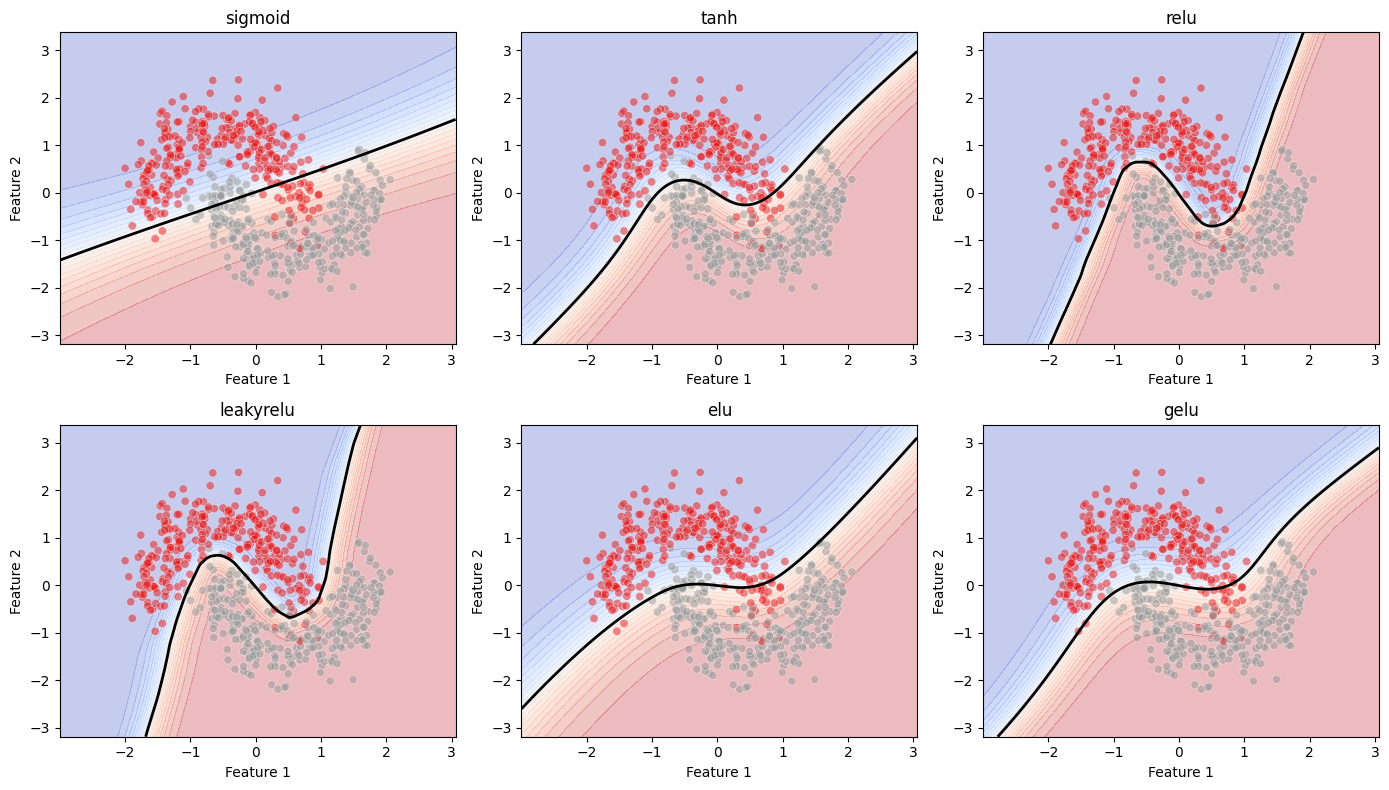

In [12]:
plot_decision_boundaries_grid(models, X_test, y_test, cfg.device)

По границам решений видно, что за 100 эпох модель с **sigmoid** даёт почти **линейное** разделение и заметно **недообучается**: переход между классами размыт, а «полосы уверенности» широкие — модель часто остаётся в зоне неопределённости. Это похоже на эффект насыщения сигмоиды и слабых градиентов, из-за чего сложную нелинейную границу ей выучить трудно за то же число эпох.

Активации из семейства ReLU (**relu** и **leakyrelu (α=0.1)**) формируют наиболее «решительные» границы: переход между классами резче, и области уверенности выглядят более однозначно. **LeakyReLU** при этом обычно стабильнее ReLU, потому что сохраняет небольшой градиент на отрицательных значениях и снижает риск «мертвых» нейронов.

**tanh**, **elu** и **gelu** дают более **плавные нелинейные** границы (особенно elu/gelu) — они лучше подстраиваются под изгиб данных и часто дают более ровную «калибровку» уверенности (меньше резких скачков вероятности), чем чистый ReLU.

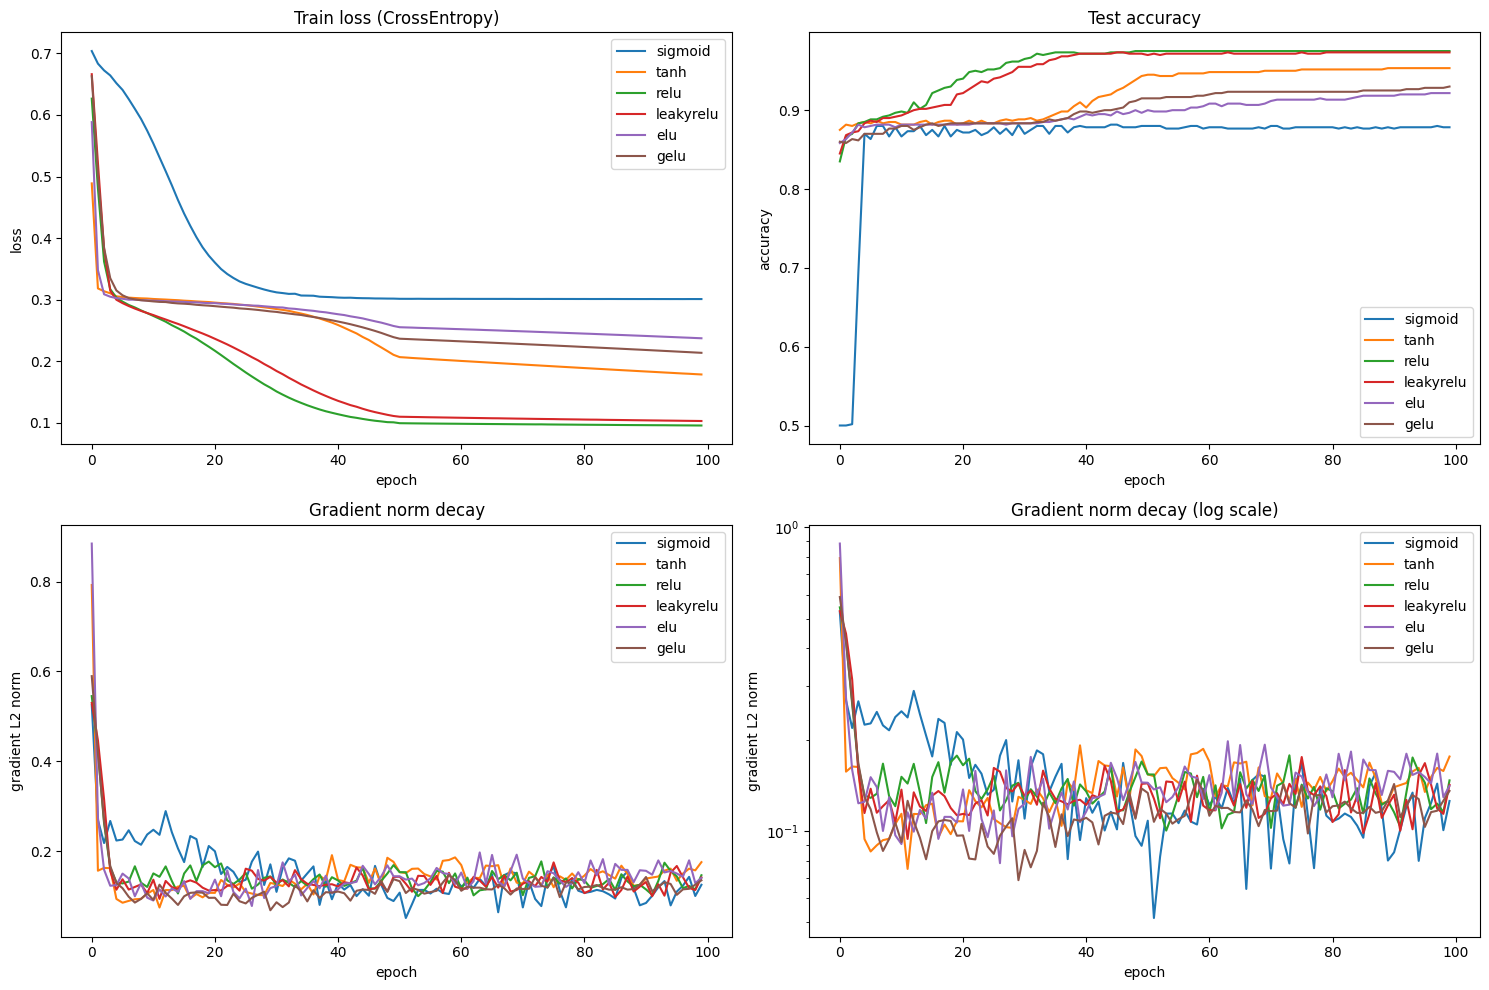

In [13]:
plot_histories_panel(results)

По графику **test accuracy** видно, что **sigmoid** довольно быстро выходит на плато и достигает своего максимума примерно к **35–45 эпохе**, после чего качество почти не улучшается (итог около **0.878**). Это согласуется и с **train loss**: у sigmoid лосс заметно выше остальных и рано «застывает» — модель недоизвлекает нелинейность и обучается хуже.

Наилучший результат показывают активации из семейства **ReLU**: **relu** и **leakyrelu (α=0.1)** выходят на максимальную точность около **0.96–0.963** и держат её стабильно. При этом у них и **train loss** минимален (самое быстрое и глубокое снижение), что говорит о более эффективной оптимизации в этой задаче.

**tanh**, **elu** и **gelu** занимают промежуточное положение: их точность растёт плавнее и в итоге немного ниже ReLU-семейства (примерно **0.91–0.94** по графику), а train loss также выше, чем у relu/leakyrelu.

По графикам **нормы градиента** (в обычной и лог-шкале) видно типичную картину: резкое падение в первые эпохи и дальнейшие колебания в относительно узком диапазоне. **Признаков взрывных градиентов (резких всплесков) или затухания “в ноль” не наблюдается** — обучение в целом стабильное. Максимум можно отметить, что у sigmoid в начале колебания выглядят чуть более «шумными», но критических проблем по градиентам на этих кривых нет.

### 2) Глубина сети

In [ ]:
class SecondMLP(nn.Module):
    """A deeper MLP with a configurable number of hidden layers.

    Note: This matches your original construction pattern (no behavioral changes),
    but be aware that the `*[nn.Linear(...), nn.ReLU()] * hidden_layers` pattern
    repeats the *same module objects*; if you want distinct layers, build them
    in a loop instead.

    Args:
        hidden_layers: Number of (Linear + ReLU) blocks after the first projection.
        hidden: Width of the hidden layers.
    """

    def __init__(self, hidden_layers: int, hidden: int = 64) -> None:
        """Initialize the MLP.

        Args:
            hidden_layers: Number of hidden layers.
            hidden: Number of units in each hidden layer.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            *[nn.Linear(hidden, hidden), nn.ReLU()] * hidden_layers,
            nn.Linear(hidden, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute logits for each class.

        Args:
            x: Input tensor of shape (N, 2).

        Returns:
            Logits tensor of shape (N, 2).
        """
        return self.net(x)

In [15]:
models = {}
results = {}

for n_layers in range(1, 8):
    name = f"{n_layers} hidden layers"
    model = SecondMLP(n_layers).to(cfg.device)
    model, hist = train_one(
        model=model,
        title=name,
        train_loader=train_loader,
        X_test_t=X_test_t,
        y_test=y_test,
        device=cfg.device,
    )
    models[name] = model
    results[name] = hist

7 hidden layers: 100%|██████████| 100/100 [00:04<00:00, 21.85it/s, test_acc=0.9750, train_acc=0.9658, train_loss=0.0829]


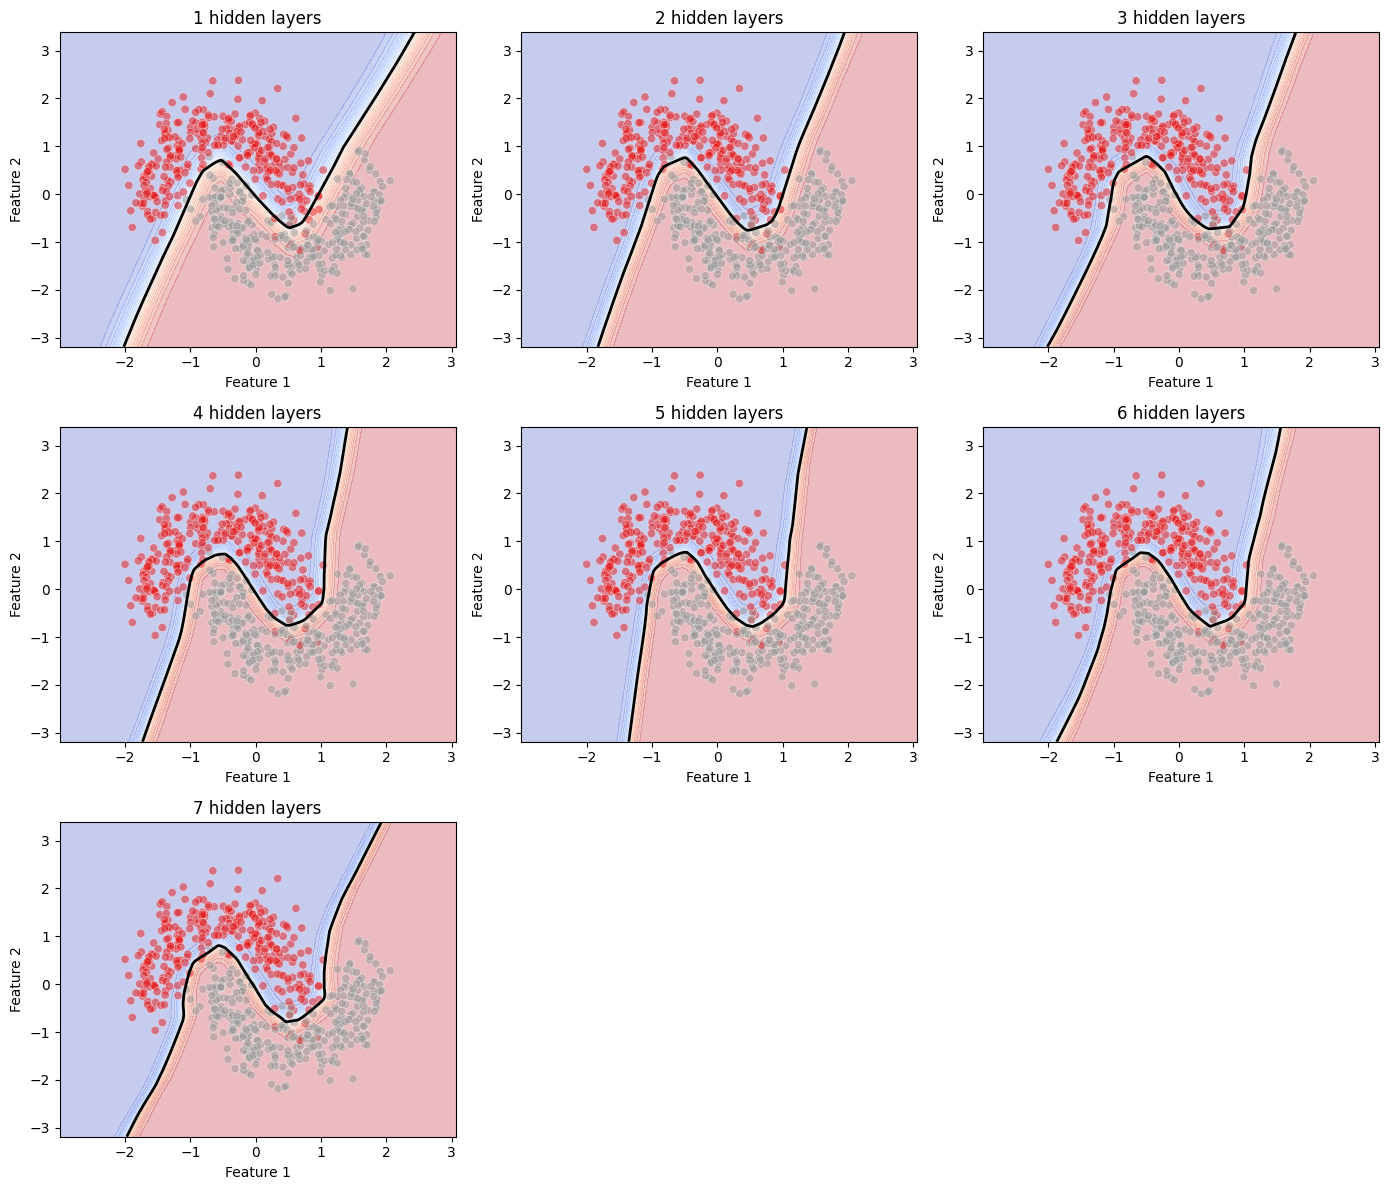

In [16]:
plot_decision_boundaries_grid(models, X_test, y_test, cfg.device)

По картам границы решений видно, что при увеличении числа скрытых слоёв с **1 до 6** форма разделяющей поверхности меняется **незначительно**: модель уже с 1–2 слоями умеет аппроксимировать нужную нелинейную границу, а дальнейшее углубление сети даёт в основном косметические изменения (чуть сдвигается положение и «резкость» перехода). Это говорит о том, что для данной простой 2D-задачи **глубина после 2–3 слоёв становится избыточной**: ёмкости модели уже достаточно.

При этом вариант с **7 скрытыми слоями** ведёт себя заметно хуже: граница становится **почти линейной/слишком сглаженной** и перестаёт корректно отделять классы. Это похоже на проблемы оптимизации в глубокой MLP без дополнительных приёмов стабилизации (нормализация, skip-connections и т.п.): сеть труднее обучить, и она может «схлопываться» к более простой функции (недообучение), даже имея большую ёмкость.

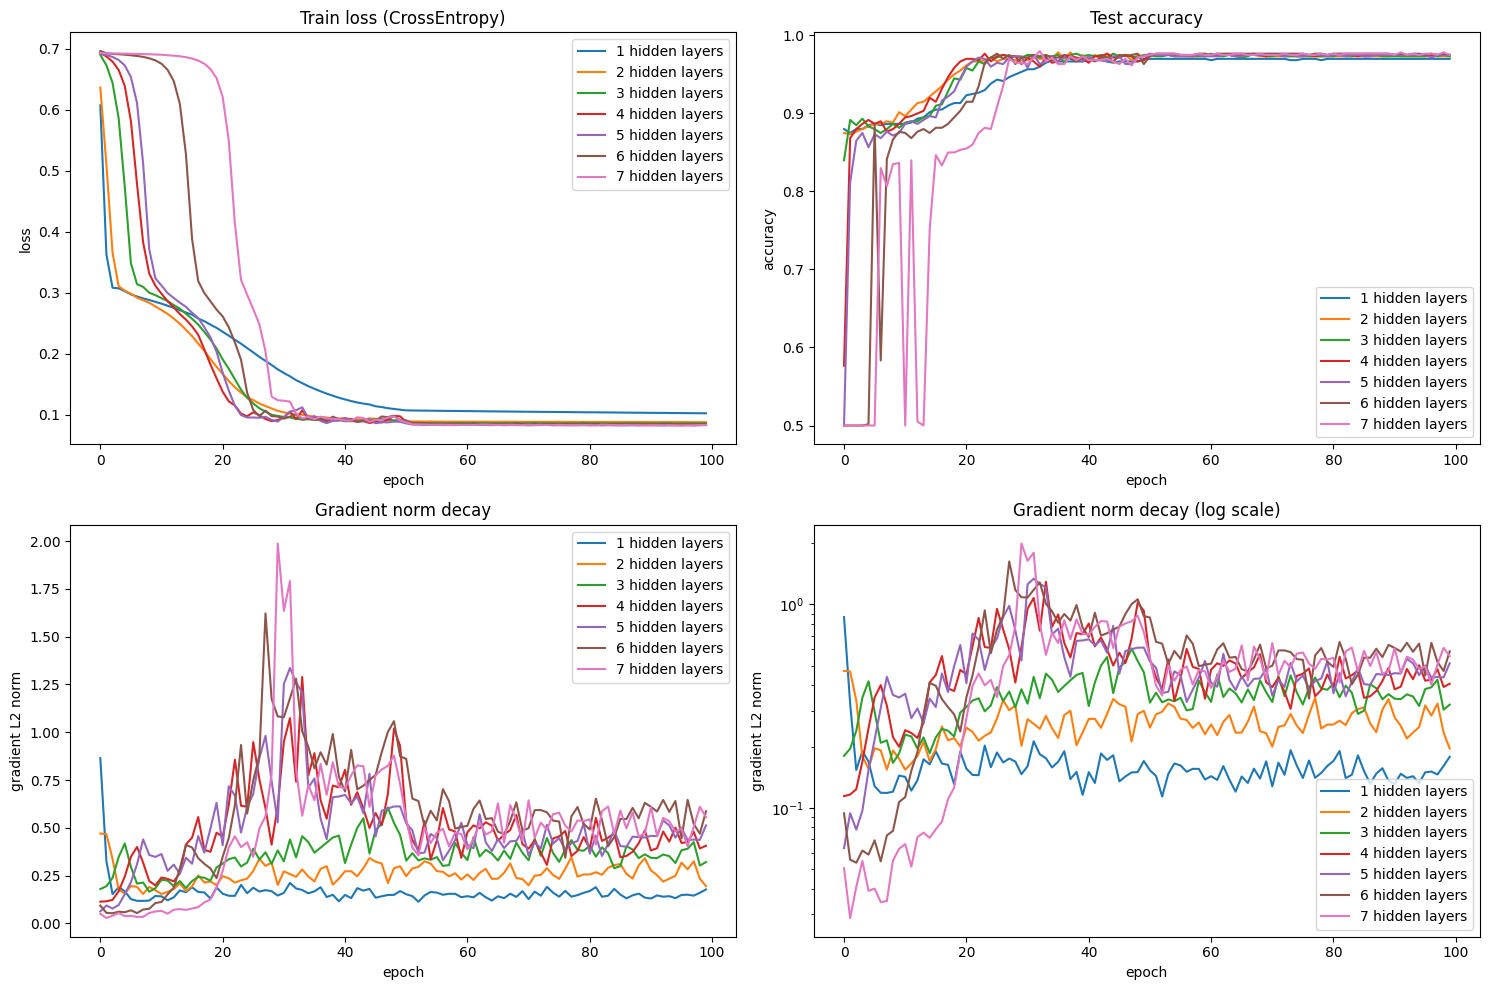

In [17]:
plot_histories_panel(results)

По графикам нормы градиента видно, что при увеличении глубины до **4–6 скрытых слоёв** появляется выраженный **пик (всплеск) градиента** примерно в районе **25–45 эпох**. Это похоже на эпизод **нестабильности оптимизации** (локальное “разбалтывание” шагов), после которого градиенты возвращаются к более устойчивому диапазону и сеть всё же сходится (что видно по падению train loss и росту accuracy).

Для модели с **7 скрытыми слоями** ситуация другая: норма градиента на всём протяжении обучения остаётся **значительно меньше**, и одновременно **train loss почти не уменьшается** (держится около ~0.69), а **test accuracy** сильно хуже и нестабильна. Это уже похоже на **затухающие градиенты и недообучение**: веса обновляются слишком слабо, модель не может выучить разделяющую границу.

### 3) Ширина сети

In [ ]:
class ThirdMLP(nn.Module):
    """A fixed-depth MLP with configurable width.

    Architecture:
        2 -> hidden -> hidden -> hidden -> 2
    with ReLU activations between hidden layers.

    Args:
        hidden: Width of each hidden layer.
    """

    def __init__(self, hidden: int = 64) -> None:
        """Initialize the MLP.

        Args:
            hidden: Number of units in each hidden layer.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute logits for each class.

        Args:
            x: Input tensor of shape (N, 2).

        Returns:
            Logits tensor of shape (N, 2).
        """
        return self.net(x)

In [19]:
models = {}
results = {}

for scale in range(2, 11):
    name = f"{2**scale:>4} hidden width"
    model = ThirdMLP(2**scale).to(cfg.device)
    model, hist = train_one(
        model=model,
        title=name,
        train_loader=train_loader,
        X_test_t=X_test_t,
        y_test=y_test,
        device=cfg.device,
    )
    models[name] = model
    results[name] = hist

   4 hidden width:   0%|          | 0/100 [00:00<?, ?it/s]

1024 hidden width: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s, test_acc=0.9750, train_acc=0.9650, train_loss=0.0830]


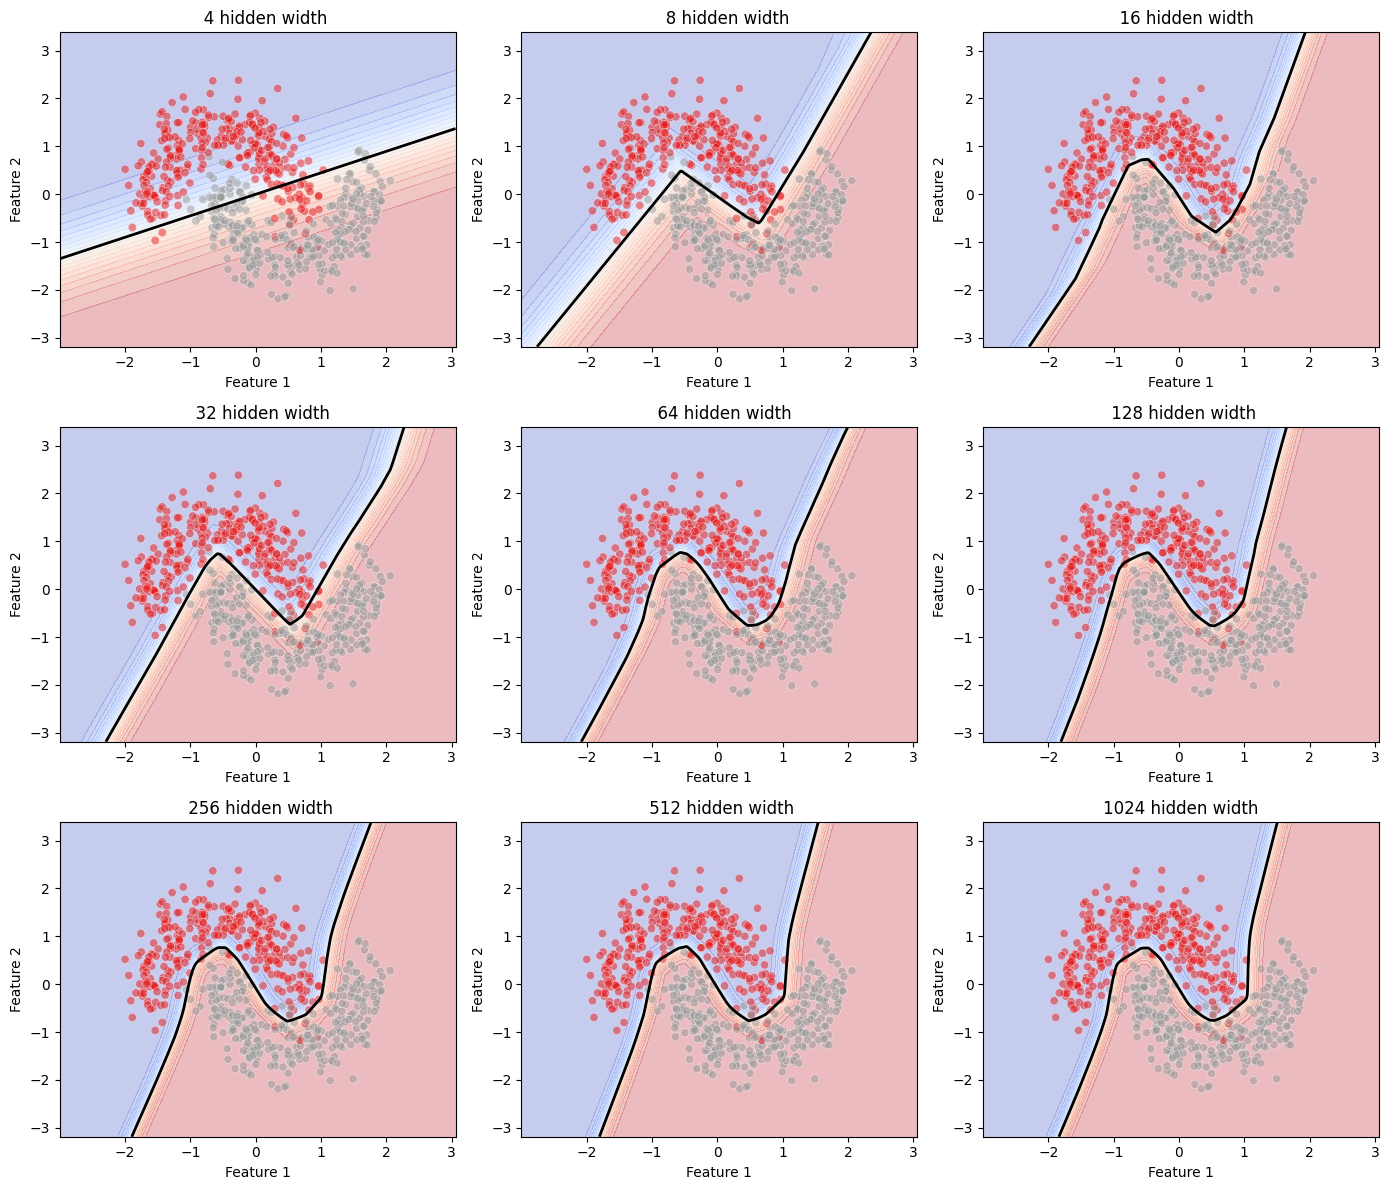

In [20]:
plot_decision_boundaries_grid(models, X_test, y_test, cfg.device)

При малой ширине скрытого слоя (**4 нейрона**) модель фактически недообучается: граница решений почти **линейная** и плохо повторяет истинную нелинейную структуру данных.

Уже при **8–16 нейронах** появляется выраженная **нелинейность** границы, и модель начинает корректно «обнимать» область между классами.

Начиная примерно с **32 нейронов** качество по виду границы почти выходит на плато: формы для **32, 64, 128, …, 1024** очень похожи, различия минимальны (в основном микросдвиги и чуть разная “резкость” перехода). Это означает, что после некоторого порога ширины **добавление нейронов почти не даёт выигрыша** на этой задаче — ёмкости модели уже достаточно.

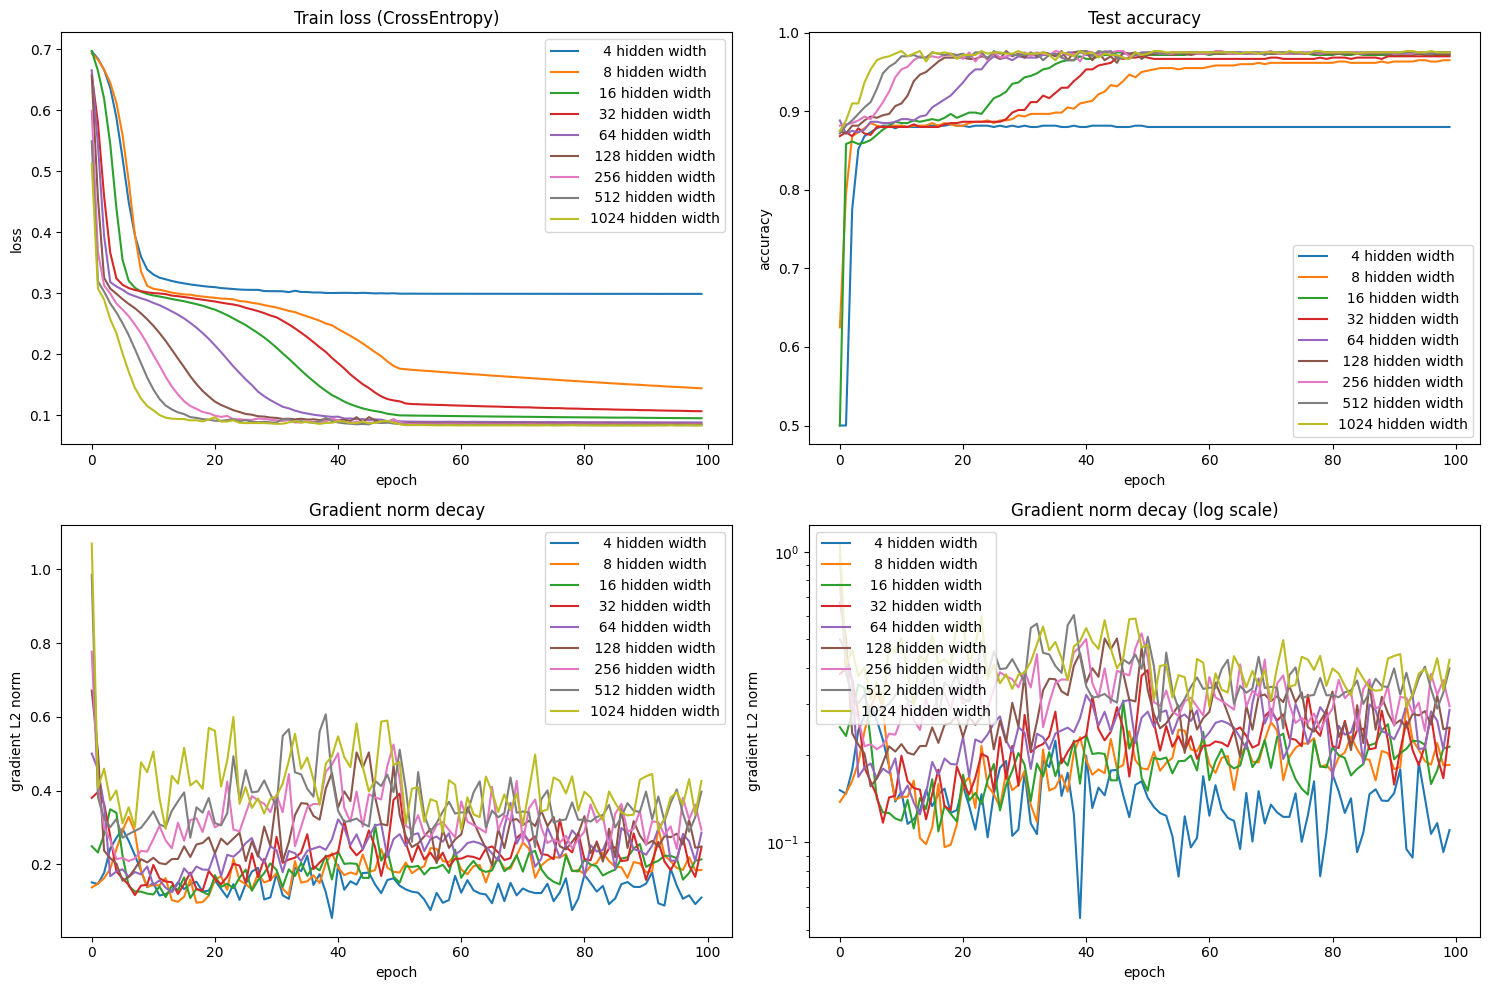

In [21]:
plot_histories_panel(results)

По графику **train loss** видно, что маленькая ширина сильно ограничивает модель: при **4 нейронах** лосс рано выходит на плато около **0.31**, т.е. сеть явно **недообучается**. При **8** и **16** лосс снижается лучше, но всё ещё заметно хуже, чем у более широких вариантов (к концу ~0.22 и ~0.16).

На графике **test accuracy** это подтверждается: **4 hidden width** даёт около **0.88** и долго “раскачивается”; **8** выходит примерно на **0.93**, **16** — около **0.95**. Начиная примерно с **32–64 нейронов** точность быстро достигает плато около **0.97–0.98**, и дальнейшее увеличение ширины (**128–1024**) почти не даёт прироста — кривые практически совпадают.

По **норме градиента** видно типичное падение в первые эпохи и затем колебания вокруг стационарного уровня. С ростом ширины этот уровень в среднем становится **выше и шумнее** (особенно у 256–1024), но признаков “взрыва” или затухания *в ноль* нет: обучение остаётся стабильным. У ширины **4** градиенты заметно меньше — это согласуется с тем, что модель слабее и обновления менее эффективны (недообучение).

**Вывод:** на задаче *make_moons* лучше всего работают **ReLU/LeakyReLU** (≈0.96–0.963), тогда как **sigmoid** заметно хуже (≈0.878) и быстрее выходит на плато. Увеличение **глубины** выше ~3 слоёв почти не даёт выигрыша, а при 4–6 слоях появляются всплески градиента; при 7 слоях обучение деградирует (затухающие градиенты, недообучение). Увеличение **ширины** улучшает качество до ~32–64 нейронов (≈0.97–0.98), дальше эффект почти пропадает.